In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os


In [2]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [16]:
import os
import shutil
import random

def split_images(source_folder, train_folder, test_folder, split_ratio=0.8):
    # Create train and test folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # List all files in the source folder
    files = os.listdir(source_folder)
    random.shuffle(files)  # Shuffle the files to randomize the order

    # Calculate the number of images for training and testing
    num_train = int(len(files) * split_ratio)
    train_files = files[:num_train]
    test_files = files[num_train:]

    # Move training images to the train folder
    for file in train_files:
        source_path = os.path.join(source_folder, file)
        dest_path = os.path.join(train_folder, file)
        shutil.copyfile(source_path, dest_path)

    # Move testing images to the test folder
    for file in test_files:
        source_path = os.path.join(source_folder, file)
        dest_path = os.path.join(test_folder, file)
        shutil.copyfile(source_path, dest_path)

    print("Images have been split successfully.")

# Example usage:
source_folder = "images/"
train_folder = "dataset/train/"
test_folder = "dataset/val/"
split_ratio = 0.8  # 80% training, 20% testing

if "dataset" in os.listdir():
    shutil.rmtree("dataset")
    
for i in os.listdir(source_folder):
    print(i)
    split_images(source_folder+i, train_folder+i, test_folder+i, split_ratio)


daisy
Images have been split successfully.
dandelion
Images have been split successfully.
rose
Images have been split successfully.
sunflower
Images have been split successfully.
tulip
Images have been split successfully.


In [3]:
# Define the data directory
data_dir = 'dataset/'
 
# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [4]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 3452, 'val': 865}


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [5]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


D:\8th sem\projects\Flower_recog_Model\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\8th sem\projects\Flower_recog_Model\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Training loop
import datetime

start_time = datetime.datetime.now()
num_epochs = 30
train_loss = list()
val_loss = list()
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
            train_loss.append(epoch_loss)
        elif phase == 'val':
            val_loss.append(epoch_loss)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Epoch Number {epoch}')
        
end_time = datetime.datetime.now()

train Loss: 1.2549 Acc: 0.5895
val Loss: 0.4794 Acc: 0.8347
Epoch Number 0
train Loss: 0.9136 Acc: 0.6877
val Loss: 0.5041 Acc: 0.8405
Epoch Number 1
train Loss: 0.8363 Acc: 0.7115
val Loss: 0.3888 Acc: 0.8682
Epoch Number 2
train Loss: 0.8826 Acc: 0.6964
val Loss: 0.3634 Acc: 0.8740
Epoch Number 3
train Loss: 0.8292 Acc: 0.7132
val Loss: 0.4608 Acc: 0.8566
Epoch Number 4
train Loss: 0.8533 Acc: 0.7167
val Loss: 0.4394 Acc: 0.8416
Epoch Number 5
train Loss: 0.8091 Acc: 0.7210
val Loss: 0.4268 Acc: 0.8601
Epoch Number 6
train Loss: 0.8106 Acc: 0.7225
val Loss: 0.4167 Acc: 0.8647
Epoch Number 7
train Loss: 0.8405 Acc: 0.7170
val Loss: 0.4032 Acc: 0.8694
Epoch Number 8
train Loss: 0.8129 Acc: 0.7274
val Loss: 0.4569 Acc: 0.8509
Epoch Number 9
train Loss: 0.8495 Acc: 0.7181
val Loss: 0.4093 Acc: 0.8682
Epoch Number 10
train Loss: 0.8385 Acc: 0.7149
val Loss: 0.4209 Acc: 0.8613
Epoch Number 11
train Loss: 0.8409 Acc: 0.7123
val Loss: 0.5143 Acc: 0.8428
Epoch Number 12
train Loss: 0.8554 Acc

Training complete! in 3:29:19.634775


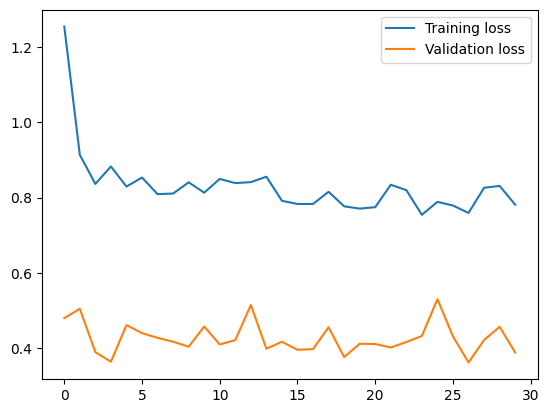

In [10]:
import matplotlib.pyplot as plt
print("Training complete! in", (str((end_time-start_time))).split()[-1])
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [11]:

# Save the model
torch.save(model.state_dict(), 'flower_classification_model_part2.pth')


# Classification on Unseen Image

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference. 

In [12]:
import torch
from torchvision import models, transforms
import torch.nn as nn
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('flower_classification_model_part2.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]




D:\8th sem\projects\Flower_recog_Model\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\8th sem\projects\Flower_recog_Model\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Load and preprocess the unseen image
# image_path = 'Sample/lily-flower.jpg'  # Replace with the path to your image
image_path = 'dataset/val/tulip/13956300996_07e64a3dbd_n.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

Perform inference using the model:

In [20]:
import os
class_names = list()
for val in os.listdir('dataset/val/'): 
    class_names.append(val)
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [21]:
# Perform inference
import torch.nn.functional as F
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
# class_names = ['daisy', 'dandelion']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

# Get class probabilities
probabilities = F.softmax(output[0], dim=0)
# Load class labels (assuming you have them)
flower_names = class_names

# Get the predicted class index and its probability
predicted_class_idx = torch.argmax(probabilities).item()
predicted_probability = probabilities[predicted_class_idx].item()

# Generate the outcome string
outcome = f"The image belongs to {class_names[predicted_class_idx]} with a score of {predicted_probability*100:.2f}%."

print(f'The predicted class is: {predicted_class_name} with \n{outcome}')


The predicted class is: tulip with 
The image belongs to tulip with a score of 99.99%.


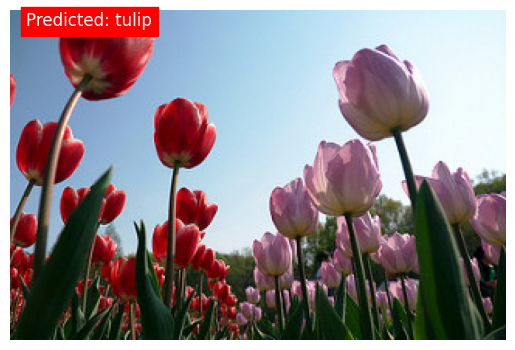

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()